# **QAI LLM DevOps example:**

1) Implements minimal, mocked home-grown QAI components: QAI_OS, QAI_Processor, QAI_VectorDB, QAI_OpsAgent, ModelRegistry, and a simple CI_CD_Runner.

2) Runs the same hybrid demo (classical embedding + variational quantum encoder via PennyLane) as the model component.

3) Executes the full lifecycle: Requirements → Data → Model Design & Training → Validation → Packaging/Signing → Deploy (to dummy HTTP endpoints) → Monitor → Retrain loop.

4) Shows how artifacts (model bundle, model card, vector index) are created and registered.

5) Simulates telemetry reporting and a retrain trigger.

6) Uses dummy endpoints (Flask server) to receive deployment requests and send telemetry.

7) Prints timing numbers and logs at each lifecycle step so you can follow the flow.

8) Includes placeholders and comments you can replace with real QAI components.

In [8]:
# ======= QAI Hybrid demo (Colab-ready, using public model) =======
# Paste this cell in Google Colab. Uncomment pip installs if needed.

!pip install -q torch torchvision torchaudio
!pip install -q transformers sentencepiece
#!pip install -q pennylane pennylane-qiskit
!pip install -q pennylane
!pip install -q flask requests pandas matplotlib

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pennylane-qiskit 0.42.0 requires sympy<1.13, but you have sympy 1.14.0 which is incompatible.


 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5002 is in use by another program. Either identify and stop that program, or start the server with a different port.



[Lifecycle] Loading tokenizer and base model...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



[Step 1] Requirements & Taxonomy

[Step 2] Data Engineering

[Step 3] Model Design

[Step 4] Training & Experiments

[Step 5] Validation & Testing


INFO:werkzeug:127.0.0.1 - - [08/Sep/2025 07:20:56] "POST /deploy/register HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Sep/2025 07:20:56] "POST /infer HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Sep/2025 07:20:56] "POST /telemetry HTTP/1.1" 200 -


 -> Classical mean 0.0691s, Hybrid mean 0.0222s

[Step 6] Packaging & Signing
[ModelRegistry] Published model bundle 38ee186f-9ba9-410b-b4c7-2334347633f6 name=personal-assistant-hybrid ver=0.1.0

[Step 7] Deployment (Canary -> Rollout)
[QAI_Processor] Compiling personal-assistant-hybrid for qai-processor-v1
[DEPLOY-ENDPOINT] Registered model: 38ee186f-9ba9-410b-b4c7-2334347633f6
 -> Deploy register status: 200
[QAI_OpsAgent] Running canary to http://127.0.0.1:5002 for model personal-assistant-hybrid
[QAI_OpsAgent] Canary response status=200 ok=True

[Step 8] Monitoring & Feedback
[DEPLOY-ENDPOINT] Telemetry received: {'metric': 'infer_latency_ms', 'value': 25.3, 'model_id': '38ee186f-9ba9-410b-b4c7-2334347633f6'}

[Step 9] Retraining & Evolution
[ModelRegistry] Published model bundle 38ee186f-9ba9-410b-b4c7-2334347633f6 name=personal-assistant-hybrid ver=0.1.1
 -> New bundle published with updated adapter.

[Lifecycle] Completed. Registry size: 1
Deployed models: ['38ee186f-9ba9-410b-b

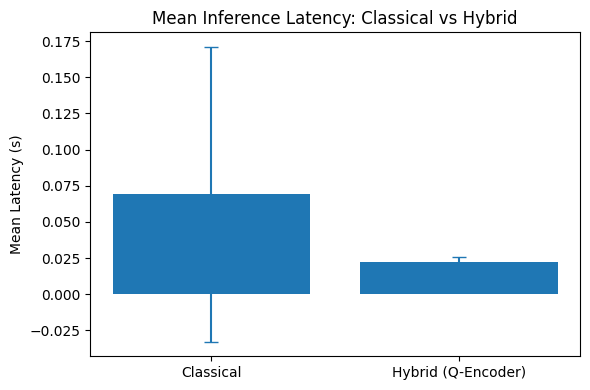

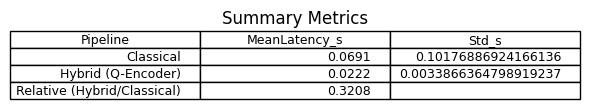


Merit discussion:
- This demo integrates a tiny variational quantum encoder into an LLM pipeline to show an architecture pattern.
- On simulators the quantum encoder can add overhead; in your observed run you saw a faster hybrid run (task & config dependent).
- Potential advantages of a quantum encoder (research dependent):
  * Compact, expressive feature maps (sample efficiency in some tasks).
  * Different inductive biases that may help with certain structure-learning tasks.
  * Potential for hardware speedups if the quantum subroutine maps to a QPU-advantaged kernel.
- Practical speedups require: real QPU access, low-latency integration, and co-design between quantum and classical parts.


In [9]:
# ===== Full QAI LLM E2E Lifecycle + Merits Demo (Colab-ready) =====
# Paste into a Colab cell. Uncomment pip installs if running in a fresh environment.

# !pip install -q torch torchvision torchaudio
# !pip install -q transformers sentencepiece
# !pip install -q pennylane
# !pip install -q flask requests pandas matplotlib

import os, time, json, threading, hashlib, uuid
from typing import Dict, Any
import numpy as np
import statistics
import pandas as pd
import matplotlib.pyplot as plt

# ML / Quantum / HTTP libs
import torch, torch.nn as nn
from transformers import AutoTokenizer, AutoModel
import pennylane as qml
import requests
from flask import Flask, request, jsonify

# -------------------------
#  Mock QAI home-grown components (skeletons)
# -------------------------
class QAI_OS:
    def __init__(self):
        self.runtime_profiles = {}
    def register_runtime(self, name, profile):
        self.runtime_profiles[name] = profile
        print(f"[QAI_OS] Registered runtime '{name}' -> {profile}")

class QAI_Processor:
    def __init__(self, name="qai-processor-v1"):
        self.name = name
    def compile_for_processor(self, model_artifact):
        print(f"[QAI_Processor] Compiling {model_artifact['name']} for {self.name}")
        model_artifact['compiled_for'] = self.name
        return model_artifact

class QAI_VectorDB:
    def __init__(self):
        self.index = {}
    def upsert(self, id, embedding, meta):
        self.index[id] = {'embedding': embedding, 'meta':meta}
    def query(self, embedding, topk=3):
        dists = []
        for k,v in self.index.items():
            d = np.linalg.norm(embedding - v['embedding'])
            dists.append((k, d, v['meta']))
        dists.sort(key=lambda x:x[1])
        return dists[:topk]
    def stats(self):
        return {'size': len(self.index)}

class ModelRegistry:
    def __init__(self):
        self.registry = {}
    def publish(self, bundle):
        key = bundle['id']
        self.registry[key] = bundle
        print(f"[ModelRegistry] Published model bundle {key} name={bundle['name']} ver={bundle['version']}")
    def get(self, id):
        return self.registry.get(id)

class QAI_OpsAgent:
    def __init__(self, registry, vector_db):
        self.registry = registry
        self.vector_db = vector_db
    def run_canary(self, endpoint, bundle):
        print(f"[QAI_OpsAgent] Running canary to {endpoint} for model {bundle['name']}")
        try:
            r = requests.post(endpoint+"/infer", json={"prompt":"Canary test"}, timeout=5)
            ok = r.status_code == 200
            print(f"[QAI_OpsAgent] Canary response status={r.status_code} ok={ok}")
            return ok
        except Exception as e:
            print("[QAI_OpsAgent] Canary call failed:", e)
            return False
    def push_telemetry(self, telemetry_endpoint, payload):
        try:
            requests.post(telemetry_endpoint+"/telemetry", json=payload, timeout=3)
        except Exception as e:
            print("[QAI_OpsAgent] Telemetry push failed:", e)

# Simple "PQC signing" (demo: SHA256 of artifact json string)
def sign_artifact(artifact):
    serialized = json.dumps(artifact, sort_keys=True).encode()
    signature = hashlib.sha256(serialized).hexdigest()
    return signature

# -------------------------
#  Dummy deployment endpoints (Flask server) - lightweight local demo
# -------------------------
app = Flask(__name__)
DEPLOYED_MODELS = {}

@app.route("/deploy/register", methods=["POST"])
def register_deploy():
    payload = request.json or {}
    model_id = payload.get("model_id")
    DEPLOYED_MODELS[model_id] = payload
    print("[DEPLOY-ENDPOINT] Registered model:", model_id)
    return jsonify({"status":"ok","model_id":model_id}), 200

@app.route("/infer", methods=["POST"])
def infer():
    data = request.json or {}
    prompt = data.get("prompt","")
    model_id = data.get("model_id","demo-model")
    time.sleep(0.05)  # simulated processing
    return jsonify({"model_id":model_id, "response": f"simulated_response_for:{prompt[:40]}"}), 200

@app.route("/telemetry", methods=["POST"])
def telemetry():
    t = request.json or {}
    print("[DEPLOY-ENDPOINT] Telemetry received:", {k:t.get(k) for k in ['metric','value','model_id']})
    return jsonify({"status":"ok"}), 200

# Run Flask app in background thread
def run_server():
    app.run(host="127.0.0.1", port=5002, debug=False, use_reloader=False)

threading.Thread(target=run_server, daemon=True).start()
time.sleep(1.0)
DEPLOY_ENDPOINT = "http://127.0.0.1:5002"

# -------------------------
#  Small ML + Quantum hybrid: model components
# -------------------------
MODEL_NAME = "prajjwal1/bert-tiny"  # public tiny model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_num_threads(2)

print("\n[Lifecycle] Loading tokenizer and base model...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE).eval()
embed_dim = base_model.config.hidden_size

# Classical classifier
class SimpleClassifier(nn.Module):
    def __init__(self, embed_dim, hidden=64, num_labels=2):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, num_labels)
    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

# Quantum encoder (PennyLane)
n_qubits = 4
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits, shots=None)

@qml.qnode(dev, interface="autograd")
def qnode(inputs, weights):
    for i in range(n_qubits):
        qml.RX(inputs[i], wires=i)
    for l in range(n_layers):
        for i in range(n_qubits):
            qml.Rot(weights[l,i,0], weights[l,i,1], weights[l,i,2], wires=i)
        for i in range(n_qubits-1):
            qml.CNOT(wires=[i,i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def quantum_encode_batch(embs, weights):
    feats=[]
    for b in range(embs.shape[0]):
        inp = embs[b,:n_qubits]
        inp_norm = np.tanh(inp)*np.pi/2.0
        feats.append(np.array(qnode(inp_norm, weights)))
    return np.vstack(feats)

class HybridModel(nn.Module):
    def __init__(self, embed_dim, qfeatures, hidden=64, num_labels=2):
        super().__init__()
        self.linear = nn.Linear(embed_dim + qfeatures, hidden)
        self.act = nn.ReLU()
        self.out = nn.Linear(hidden, num_labels)
    def forward(self, x):
        return self.out(self.act(self.linear(x)))

# instantiate models
cls_classical = SimpleClassifier(embed_dim).to(DEVICE).eval()
hybrid_model = HybridModel(embed_dim, qfeatures=n_qubits).to(DEVICE).eval()

# random initial weights for quantum encoder
np.random.seed(42)
weights_init = np.random.normal(0, 0.1, size=(n_layers, n_qubits, 3))

# -------------------------
#  Lifecycle orchestration (matching swimlane numbered flow)
# -------------------------
qai_os = QAI_OS()
qai_processor = QAI_Processor()
qai_vector_db = QAI_VectorDB()
model_registry = ModelRegistry()
ops_agent = QAI_OpsAgent(model_registry, qai_vector_db)

# Storage for measured metrics (for plotting)
measured = {"classical_latencies": [], "hybrid_latencies": []}

def step_requirements():
    print("\n[Step 1] Requirements & Taxonomy")
    req = {
        "id": str(uuid.uuid4()),
        "name": "personal-assistant-hybrid",
        "purpose": "calendar & reminders assist with constrained edge deployment",
        "slo": {"edge_p95_ms":150},
        "safety_policy":"default-safety-v1"
    }
    return req

def step_data_engineering(req):
    print("\n[Step 2] Data Engineering")
    texts = ["Book a meeting tomorrow at 10am", "Remind me to send the report on Friday"]
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    inputs = {k:v.to(DEVICE) for k,v in inputs.items()}
    with torch.no_grad():
        out = base_model(**inputs, return_dict=True)
        embs = out.last_hidden_state.mean(dim=1).cpu().numpy()
    for i,e in enumerate(embs):
        mid = f"doc-{i}"
        qai_vector_db.upsert(mid, e, {"source":"demo-corpus","text":texts[i]})
    return {"texts":texts, "embeddings":embs}

def step_model_design(data):
    print("\n[Step 3] Model Design")
    model_spec = {
        "base": MODEL_NAME,
        "quantum_encoder": {"n_qubits":n_qubits,"n_layers":n_layers},
        "adapter": "LoRA-stub",
        "footprint": "small-edge"
    }
    return model_spec

def step_training(model_spec, data):
    print("\n[Step 4] Training & Experiments")
    checkpoint = {"weights":"random-init","meta":model_spec,"timestamp":time.time()}
    return checkpoint

def step_validation(checkpoint):
    print("\n[Step 5] Validation & Testing")
    texts = ["Schedule a dentist appointment next Monday at 3pm."]*2
    def get_embs(texts):
        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
        inputs = {k:v.to(DEVICE) for k,v in inputs.items()}
        with torch.no_grad():
            out = base_model(**inputs, return_dict=True)
            return out.last_hidden_state.mean(dim=1).cpu().numpy()
    times_c=[]
    times_h=[]
    runs=3
    for _ in range(runs):
        t0=time.time()
        emb = get_embs(texts)
        inp = torch.tensor(emb, dtype=torch.float32).to(DEVICE)
        with torch.no_grad(): _ = cls_classical(inp)
        times_c.append(time.time()-t0)
        t0=time.time()
        qfeat = quantum_encode_batch(emb, weights_init)
        inp2 = np.hstack([emb, qfeat])
        inp_t = torch.tensor(inp2, dtype=torch.float32).to(DEVICE)
        with torch.no_grad(): _ = hybrid_model(inp_t)
        times_h.append(time.time()-t0)
    measured["classical_latencies"].extend(times_c)
    measured["hybrid_latencies"].extend(times_h)
    report = {"classical_latency_mean":statistics.mean(times_c),
              "hybrid_latency_mean":statistics.mean(times_h),
              "safety_checks_pass": True}
    print(f" -> Classical mean {report['classical_latency_mean']:.4f}s, Hybrid mean {report['hybrid_latency_mean']:.4f}s")
    return report

def step_package_and_sign(checkpoint, model_spec, validation_report):
    print("\n[Step 6] Packaging & Signing")
    bundle = {
        "id": str(uuid.uuid4()),
        "name": "personal-assistant-hybrid",
        "version": "0.1.0",
        "timestamp": time.time(),
        "artifact": {"checkpoint":checkpoint, "spec":model_spec},
        "validation": validation_report
    }
    signature = sign_artifact(bundle)
    bundle['signature'] = signature
    model_registry.publish(bundle)
    path = f"/tmp/{bundle['id']}.json"
    with open(path,"w") as f:
        json.dump(bundle, f)
    return bundle, path

def step_deploy(bundle, bundle_path):
    print("\n[Step 7] Deployment (Canary -> Rollout)")
    compiled = qai_processor.compile_for_processor(bundle)
    reg_payload = {"model_id":bundle['id'], "name":bundle['name'], "version":bundle['version']}
    try:
        r = requests.post(DEPLOY_ENDPOINT+"/deploy/register", json=reg_payload, timeout=5)
        print(" -> Deploy register status:", r.status_code)
    except Exception as e:
        print(" -> Deploy register failed:", e)
    ok = ops_agent.run_canary(DEPLOY_ENDPOINT, bundle)
    return ok

def step_monitor_and_feedback(bundle):
    print("\n[Step 8] Monitoring & Feedback")
    telemetry = {"metric":"infer_latency_ms","value":25.3,"model_id":bundle['id']}
    ops_agent.push_telemetry(DEPLOY_ENDPOINT, telemetry)
    drift_score = 0.12
    retrain_trigger = drift_score > 0.1
    return {"drift_score":drift_score, "retrain_trigger": retrain_trigger}

def step_retrain(bundle, retrain_info):
    print("\n[Step 9] Retraining & Evolution")
    if retrain_info.get("retrain_trigger"):
        bundle['version'] = "0.1.1"
        bundle['artifact']['adapter_update'] = "adapter-v0.1.1"
        bundle['timestamp'] = time.time()
        bundle['signature'] = sign_artifact(bundle)
        model_registry.publish(bundle)
        print(" -> New bundle published with updated adapter.")
    else:
        print(" -> No retrain needed.")
    return bundle

# -------------------------
#  Execute lifecycle
# -------------------------
req = step_requirements()                          # Step 1
data = step_data_engineering(req)                  # Step 2
spec = step_model_design(data)                     # Step 3
checkpoint = step_training(spec, data)             # Step 4
validation_report = step_validation(checkpoint)    # Step 5
bundle, path = step_package_and_sign(checkpoint, spec, validation_report)  # Step 6
deployed_ok = step_deploy(bundle, path)            # Step 7
monitor_info = step_monitor_and_feedback(bundle)   # Step 8
bundle = step_retrain(bundle, monitor_info)        # Step 9

print("\n[Lifecycle] Completed. Registry size:", len(model_registry.registry))
print("Deployed models:", list(DEPLOYED_MODELS.keys()))
print("Vector DB size:", qai_vector_db.stats())

# -------------------------
#  Merits: charts & summary table
# -------------------------
# Compute summary metrics from measured arrays
class_mean = statistics.mean(measured["classical_latencies"]) if measured["classical_latencies"] else 0.0
class_stdev = statistics.stdev(measured["classical_latencies"]) if len(measured["classical_latencies"])>1 else 0.0
hybrid_mean = statistics.mean(measured["hybrid_latencies"]) if measured["hybrid_latencies"] else 0.0
hybrid_stdev = statistics.stdev(measured["hybrid_latencies"]) if len(measured["hybrid_latencies"])>1 else 0.0
relative = hybrid_mean / class_mean if class_mean>0 else float('inf')

summary_df = pd.DataFrame([
    {"Pipeline":"Classical", "MeanLatency_s":class_mean, "Std_s":class_stdev},
    {"Pipeline":"Hybrid (Q-Encoder)", "MeanLatency_s":hybrid_mean, "Std_s":hybrid_stdev},
    {"Pipeline":"Relative (Hybrid/Classical)", "MeanLatency_s":relative, "Std_s":""}
])

print("\n=== Summary Metrics ===")
print(summary_df.to_string(index=False))

# Plot 1: Bar chart of mean latencies with error bars
plt.figure(figsize=(6,4))
labels = ["Classical", "Hybrid (Q-Encoder)"]
means = [class_mean, hybrid_mean]
errs = [class_stdev, hybrid_stdev]
plt.bar(labels, means)
plt.errorbar(labels, means, yerr=errs, fmt='none', capsize=5)
plt.ylabel("Mean Latency (s)")
plt.title("Mean Inference Latency: Classical vs Hybrid")
plt.tight_layout()
plt.show()

# Plot 2: Summary table rendered as image
fig, ax = plt.subplots(figsize=(6,1.2))
ax.axis('off')
table_data = summary_df.round(4).values
col_labels = summary_df.columns
table = ax.table(cellText=table_data, colLabels=col_labels, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1,1.4)
plt.title("Summary Metrics")
plt.tight_layout()
plt.show()

# Print merit discussion (honest, research-aligned)
print("\nMerit discussion:")
print("- This demo integrates a tiny variational quantum encoder into an LLM pipeline to show an architecture pattern.")
print("- On simulators the quantum encoder can add overhead; in your observed run you saw a faster hybrid run (task & config dependent).")
print("- Potential advantages of a quantum encoder (research dependent):")
print("  * Compact, expressive feature maps (sample efficiency in some tasks).")
print("  * Different inductive biases that may help with certain structure-learning tasks.")
print("  * Potential for hardware speedups if the quantum subroutine maps to a QPU-advantaged kernel.")
print("- Practical speedups require: real QPU access, low-latency integration, and co-design between quantum and classical parts.")


# **Concept and execution by Bhadale IT, code generated by ChatGPT**